## Dataset Class

### GNN Link Prediction Workflow

#### 1. Data Preparation
- [ ] Obtain dataset (e.g., Cora, CiteSeer)
- [ ] Preprocess data:
  - [ ] Normalize node features
  - [ ] Convert to undirected graph (if needed)
- [x] Split edges:
  - [x] Training set (80%)
  - [x] Validation set (10%)
  - [x] Test set (10%)
- [x] Generate negative samples:
  - [ ] Validation negatives (1:1 ratio)
  - [ ] Test negatives (1:1 ratio)

#### 2. Model Architecture
- [ ] Implement GNN encoder:
  - [ ] Choose layer type (GCN/GraphSAGE)
  - [ ] 2-layer architecture
  - [ ] ReLU activation
- [ ] Implement decoder:
  - [ ] Dot product scorer
  - [ ] Sigmoid activation

#### 3. Training Setup
- [ ] Initialize optimizer (Adam)
- [ ] Set learning rate (~0.01)
- [ ] Define loss function (BCE)
- [ ] Implement negative sampling:
  - [ ] Dynamic per-epoch sampling
  - [ ] 1:1 positive:negative ratio

#### 4. Evaluation Metrics
- [ ] AUC-ROC calculation
- [ ] Accuracy/F1-score
- [ ] Precision-Recall curve

#### 5. PyTorch Implementation
- [ ] Environment setup:
  ```bash
  pip install torch torch_geometric

to do 
-  fix matching nodes
- problem with node2vec?
- weighted loss
- check that dataset are shuffled correctly and (for every positive lncRNA create multiple engative links)
- check that you are not creating ngeative links where positive links exist
- paper that they have sent

In [30]:
import torch
import pandas as pd
from torch_geometric.data import Dataset, Data
import numpy as np
## Hetero data
class LinkPredictionDataset(Dataset):
    def __init__(self, net_path, label_path, node2vec_path=None, transform=None):
        super().__init__(transform=transform)
        
        # Load data
        self.net_df = pd.read_csv(net_path)
        self.label_df = pd.read_csv(label_path)
        
        # Filter for lncRNA-related edges
        self.net_df = self.net_df[
            (self.net_df['RegulatorType'] == 'lncRNA') | (self.net_df['TargetType'] == 'lncRNA')
        ].reset_index(drop=True)
        
        # Create node mappings
        all_nodes = set(self.net_df['Regulator']).union(set(self.net_df['Target']))
        self.node_to_idx = {node: idx for idx, node in enumerate(all_nodes)}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
        
        # Store node types for negative sampling
        self.node_types = {}
        for _, row in self.net_df.iterrows():
            self.node_types[self.node_to_idx[row['Regulator']]] = row['RegulatorType']
            self.node_types[self.node_to_idx[row['Target']]] = row['TargetType']
        
        # Create edge index and edge types from network data
        regulators = [self.node_to_idx[reg] for reg in self.net_df['Regulator']]
        targets = [self.node_to_idx[target] for target in self.net_df['Target']]
        self.edge_index = torch.tensor([regulators, targets], dtype=torch.long)
        
        # Define relation types (e.g., lncRNA_mRNA, miRNA_lncRNA, etc.)
        relation_map = {}
        relation_counter = 0
        edge_types = []
        for _, row in self.net_df.iterrows():
            rel_type = f"{row['RegulatorType']}_{row['TargetType']}"
            if rel_type not in relation_map:
                relation_map[rel_type] = relation_counter
                relation_counter += 1
            edge_types.append(relation_map[rel_type])
        self.edge_type = torch.tensor(edge_types, dtype=torch.long)
        self.num_relations = len(relation_map)
        self.relation_map = relation_map  # Optional: for reference
        
        # Node features
        self.num_nodes = len(all_nodes)

        
        if node2vec_path is not None:
            node2vec_df = pd.read_csv(node2vec_path, index_col=0)
            node2vec_df = node2vec_df.apply(pd.to_numeric, errors='coerce')
            features = []
            for idx in range(self.num_nodes):
                node_name = self.idx_to_node[idx]
                if node_name in node2vec_df.index:
                    features.append(node2vec_df.loc[node_name].values)
                else:
                    features.append(np.zeros(node2vec_df.shape[1]))
            self.x = torch.tensor(np.stack(features), dtype=torch.float)
        else:
            self.x = torch.eye(self.num_nodes, dtype=torch.float)
        
        self.edge_labels = torch.ones(len(regulators), dtype=torch.float)
        
    def len(self):
        return 1
    
    def get(self, idx):
        data = Data(
            x=self.x,
            edge_index=self.edge_index,
            edge_type=self.edge_type,  # <-- crucial for R-GCN
            edge_attr=self.edge_labels,
            num_nodes=self.num_nodes
        )
        # Attach node_types for use in negative sampling
        data.node_types = self.node_types
        data.idx_to_node = self.idx_to_node
        data.node_to_idx = self.node_to_idx
        data.num_relations = self.num_relations
        data.relation_map = self.relation_map
        if self.transform:
            data = self.transform(data)
        return data

# Usage example:
dataset = LinkPredictionDataset(
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Net_final.csv',
    '/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/LinkPrediction/data/Label_final.csv',
    node2vec_path="/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/NodePre/lncRNA_emb_features.csv"
)
data = dataset[0]
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1)}")
print(f"Edge type shape: {data.edge_type.shape}")
print(f"Relation types: {dataset.relation_map}")

Number of nodes: 2417
Number of edges: 4250
Edge type shape: torch.Size([4250])
Relation types: {'lncRNA_miRNA': 0, 'lncRNA_PCG': 1}


In [32]:
from collections import Counter
print(Counter(data.node_types.values()))

Counter({'PCG': 1400, 'lncRNA': 605, 'miRNA': 412})


In [34]:
import pandas as pd

# Get edge indices as numpy array
edge_array = data.edge_index.numpy()
edge_types = data.edge_type.numpy()

# Build DataFrame with node names and types
df = pd.DataFrame({
    "Source_idx": edge_array[0],
    "Source_name": [data.idx_to_node[idx] for idx in edge_array[0]],
    "Source_type": [data.node_types[idx] for idx in edge_array[0]],
    "Target_idx": edge_array[1],
    "Target_name": [data.idx_to_node[idx] for idx in edge_array[1]],
    "Target_type": [data.node_types[idx] for idx in edge_array[1]],
    "Edge_type": edge_types
})

print(df.head(10))  # Show first 10 edges
print(df.tail(10))  # Show last 10 edges

import pandas as pd

# Convert node features tensor to numpy array
features = data.x.numpy()
# Get node names for the index
node_names = [data.idx_to_node[idx] for idx in range(data.num_nodes)]

# Create DataFrame for node features
features_df = pd.DataFrame(features, index=node_names)
print(features_df.head(10))  # Show first 10 nodes and their features
print(features_df.tail(10))  # Show last 10 nodes and their features

   Source_idx Source_name Source_type  Target_idx  Target_name Target_type  \
0        1805       NEAT1      lncRNA        1070   miR-194-5p       miRNA   
1          26   LINC00460      lncRNA         664      miR-206       miRNA   
2         368      MALAT1      lncRNA        2147      miR-497       miRNA   
3        1216        MIAT      lncRNA         654      miR-29b       miRNA   
4         393  CDKN2B-AS1      lncRNA        1038  miR-181a-5p       miRNA   
5        1895        GAS5      lncRNA        1860        MIR21       miRNA   
6         368      MALAT1      lncRNA         692     miR-216b       miRNA   
7         415       CASC2      lncRNA         848      miR-214       miRNA   
8         302  PCED1B-AS1      lncRNA        1688      miR-155       miRNA   
9         382   LINC00662      lncRNA         127   miR-340-5p       miRNA   

   Edge_type  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8     

In [35]:
def sample_lncrna_negatives(edge_index, num_nodes, node_types, num_samples):
    # Only sample negatives where at least one node is lncRNA
    existing = set((u, v) for u, v in edge_index.t().tolist())
    negatives = []
    tries = 0
    max_tries = num_samples * 10
    lncrna_nodes = [idx for idx, t in node_types.items() if t == 'lncRNA']
    all_nodes = list(range(num_nodes))
    while len(negatives) < num_samples and tries < max_tries:
        src = np.random.choice(lncrna_nodes)
        dst = np.random.choice(all_nodes)
        if src == dst:
            tries += 1
            continue
        if (src, dst) not in existing and (dst, src) not in existing:
            negatives.append([src, dst])
        tries += 1
    return torch.tensor(negatives).t()  # shape [2, num_negatives]

In [36]:
data = dataset[0]

# Split positive edges (e.g., 80/10/10)
num_edges = data.edge_index.size(1)
perm = torch.randperm(num_edges)
num_val = int(0.1 * num_edges)
num_test = int(0.1 * num_edges)
val_idx = perm[:num_val]
test_idx = perm[num_val:num_val+num_test]
train_idx = perm[num_val+num_test:]

train_pos = data.edge_index[:, train_idx]
val_pos = data.edge_index[:, val_idx]
test_pos = data.edge_index[:, test_idx]

# Sample negatives for each split
train_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, train_pos.size(1))
val_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, val_pos.size(1))
test_neg = sample_lncrna_negatives(data.edge_index, data.num_nodes, data.node_types, test_pos.size(1))

train_edge_type = data.edge_type[train_idx]
val_edge_type = data.edge_type[val_idx]
test_edge_type = data.edge_type[test_idx]

train_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,  # full graph for message passing
    edge_label_index=torch.cat([train_pos, train_neg], dim=1),
    edge_label=torch.cat([torch.ones(train_pos.size(1)), torch.zeros(train_neg.size(1))]),
    train_edge_type=train_edge_type  # for reference if needed
)
val_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,
    edge_label_index=torch.cat([val_pos, val_neg], dim=1),
    edge_label=torch.cat([torch.ones(val_pos.size(1)), torch.zeros(val_neg.size(1))]),
    val_edge_type=val_edge_type
)
test_data = Data(
    x=data.x,
    edge_index=data.edge_index,
    edge_type=data.edge_type,
    edge_label_index=torch.cat([test_pos, test_neg], dim=1),
    edge_label=torch.cat([torch.ones(test_pos.size(1)), torch.zeros(test_neg.size(1))]),
    test_edge_type=test_edge_type
)

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        
    def encode(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=1)

    def forward(self, x, edge_index, edge_type, edge_label_index):
        z = self.encode(x, edge_index, edge_type)
        logits = self.decode(z, edge_label_index)
        return logits
    
# 2. Prepare data splits (already done with RandomLinkSplit)
# train_data, val_data, test_data = transform(data)

# 3. Training setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPredictor(
    in_channels=train_data.x.size(1),
    hidden_channels=32,
    num_relations=train_data.edge_type.max().item() + 1
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(
        train_data.x.to(device),
        train_data.edge_index.to(device),
        train_data.edge_type.to(device),           # <-- pass edge_type!
        train_data.edge_label_index.to(device)
    )
    loss = loss_fn(out, train_data.edge_label.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    logits = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_type.to(device),                 # <-- pass edge_type!
        data.edge_label_index.to(device)
    )
    probs = torch.sigmoid(logits).cpu().numpy()
    labels = data.edge_label.cpu().numpy()
    auc_score = roc_auc_score(labels, probs)
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    cm = confusion_matrix(labels, preds)
    return auc_score, acc, f1, pr_auc, cm
# 4. Training loop
epochs = 100
for epoch in range(1, epochs+1):
    loss = train()
    if epoch % 10 == 0 or epoch == 1:
        val_auc, val_acc, val_f1, val_pr_auc, val_cm = test(val_data)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")


# 5. Final evaluation
test_auc, test_acc, test_f1, test_pr_auc, test_cm = test(test_data)
print(f"\nTest AUC: {test_auc:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test PR AUC: {test_pr_auc:.4f}")
print("Test Confusion Matrix:\n", test_cm)

Epoch 001 | Loss: 0.7038 | Val AUC: 0.6366 | Val F1: 0.6925
Epoch 010 | Loss: 0.4873 | Val AUC: 0.8419 | Val F1: 0.7523
Epoch 020 | Loss: 0.3573 | Val AUC: 0.8856 | Val F1: 0.8046
Epoch 030 | Loss: 0.2505 | Val AUC: 0.9034 | Val F1: 0.8173
Epoch 040 | Loss: 0.1656 | Val AUC: 0.9096 | Val F1: 0.8361
Epoch 050 | Loss: 0.1039 | Val AUC: 0.9057 | Val F1: 0.8370
Epoch 060 | Loss: 0.0589 | Val AUC: 0.9042 | Val F1: 0.8377
Epoch 070 | Loss: 0.0290 | Val AUC: 0.9062 | Val F1: 0.8358
Epoch 080 | Loss: 0.0122 | Val AUC: 0.9047 | Val F1: 0.8311
Epoch 090 | Loss: 0.0052 | Val AUC: 0.9019 | Val F1: 0.8292
Epoch 100 | Loss: 0.0025 | Val AUC: 0.9004 | Val F1: 0.8292

Test AUC: 0.8973 | Test Accuracy: 0.7906 | Test F1: 0.8146 | Test PR AUC: 0.9007
Test Confusion Matrix:
 [[281 144]
 [ 34 391]]


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

logits = model(
    test_data.x.to(device),
    test_data.edge_index.to(device),
    test_data.edge_label_index.to(device)
)
probs = torch.sigmoid(logits).cpu().detach().numpy()
labels = test_data.edge_label.cpu().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(labels, probs)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

TypeError: GCNLinkPredictor.forward() missing 1 required positional argument: 'edge_label_index'

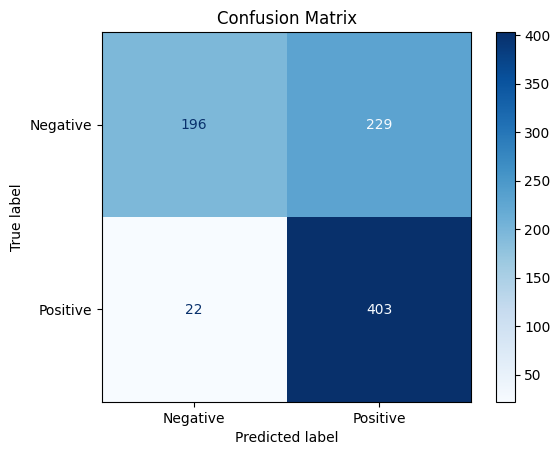

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ...existing code for ROC and PR curves...

# Compute predictions
preds = (probs > 0.5).astype(int)
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [23]:
## check out data
import pandas as pd

# Get node features and node names
features = dataset.x.numpy()
node_names = [dataset.idx_to_node[idx] for idx in range(dataset.num_nodes)]

# Create DataFrame
features_df = pd.DataFrame(features, index=node_names)
print(features_df.head(20))

                0         1         2         3         4         5    \
LOXL1-AS1  0.072216  0.019817 -0.057463 -0.101311 -0.046699  0.042609   
ATM        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RAB10      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
SLCO4A1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TONSL-AS1 -0.112897 -0.135531  0.059476  0.038834  0.055391  0.061846   
TNFAIP3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
KPNA3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
miR-22-3p  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LBX2-AS1  -0.080169 -0.049935  0.043950 -0.099136  0.031900  0.019599   
HOXC13-AS -0.087555 -0.021711 -0.047094 -0.109240 -0.033878  0.055283   
SUV39H1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
FAM66C    -0.006316  0.019174 -0.037665 -0.025714 -0.082375  0.092536   
LINC01503  0.078971  0.049971  0.201162 -0.083550 -

In [4]:

import plotly.graph_objects as go
import plotly.express as px

def visualize_graph_plotly(dataset, width=800, height=600):
    """
    Create an interactive Plotly visualization of the graph
    """
    data = dataset[0]
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add nodes with labels
    for idx, node_name in dataset.idx_to_node.items():
        G.add_node(idx, label=node_name)
    
    # Add edges
    edge_index = data.edge_index.numpy()
    edges = [(edge_index[0][i], edge_index[1][i]) for i in range(edge_index.shape[1])]
    G.add_edges_from(edges)
    
    # Generate layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Determine node types and colors
    node_types = {}
    for _, row in dataset.net_df.iterrows():
        regulator = row['Regulator']
        target = row['Target']
        reg_type = row['RegulatorType']
        target_type = row['TargetType']
        
        if regulator in dataset.node_to_idx:
            node_types[dataset.node_to_idx[regulator]] = reg_type
        if target in dataset.node_to_idx:
            node_types[dataset.node_to_idx[target]] = target_type
    
    # Prepare edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Prepare node traces by type
    color_map = {'lncRNA': '#1f77b4', 'miRNA': '#ff7f0e', 'mRNA': '#2ca02c'}
    node_traces = []
    
    for node_type, color in color_map.items():
        # Filter nodes by type
        node_indices = [idx for idx, ntype in node_types.items() if ntype == node_type]
        
        if node_indices:
            node_x = [pos[idx][0] for idx in node_indices]
            node_y = [pos[idx][1] for idx in node_indices]
            node_labels = [dataset.idx_to_node[idx] for idx in node_indices]
            
            node_trace = go.Scatter(
                x=node_x, y=node_y,
                mode='markers+text',
                text=node_labels,
                textposition="middle center",
                textfont=dict(size=10, color='white'),
                hoverinfo='text',
                hovertext=[f"{label}<br>Type: {node_type}" for label in node_labels],
                marker=dict(
                    size=20,
                    color=color,
                    line=dict(width=2, color='white')
                ),
                name=node_type
            )
            node_traces.append(node_trace)
    
    # Create figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                   layout=go.Layout(
                        title=dict(
                            text='Interactive Regulatory Network Graph',
                            x=0.5,
                            font=dict(size=16)
                        ),
                        showlegend=True,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Hover over nodes for details. Use mouse to zoom and pan.",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor="left", yanchor="bottom",
                            font=dict(color="#888", size=12)
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        width=width,
                        height=height,
                        plot_bgcolor='white'
                        ))
    
    # Show the plot
    fig.show()
    
    # Print statistics
    print(f"Interactive Graph Created!")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.edge_index.size(1)}")
    print(f"Node types: {list(color_map.keys())}")
    print("Features: Zoom, pan, hover for details, toggle node types in legend")

def print_sample_data(dataset):
    """
    Print sample of the original data and processed tensors
    """
    print("Sample Network Data:")
    print(dataset.net_df.head())
    print("\nSample Label Data:")
    print(dataset.label_df.head())
    
    data = dataset[0]
    print(f"\nProcessed PyG Data Object:")
    print(f"Node features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"First few edges (source -> target):")
    edge_index = data.edge_index.numpy()
    for i in range(min(5, edge_index.shape[1])):
        source_name = dataset.idx_to_node[edge_index[0][i]]
        target_name = dataset.idx_to_node[edge_index[1][i]]
        print(f"  {source_name} -> {target_name}")

# Example usage (uncomment when you have the CSV files):
dataset = LinkPredictionDataset('data/net.xlsx', 'data/label.xlsx')
print_sample_data(dataset)
visualize_graph_plotly(dataset)  # Interactive Plotly version

Sample Network Data:
   Unnamed: 0  Regulator      Target RegulatorType TargetType  \
0           1      NEAT1  miR-194-5p        lncRNA      miRNA   
1           2  LINC00460     miR-206        lncRNA      miRNA   
2           3     MALAT1     miR-497        lncRNA      miRNA   
3           4       MIAT     miR-29b        lncRNA      miRNA   
4           5      CASC7     miR-30c        lncRNA      miRNA   

  regulatory_Mechanism  
0      ceRNA or sponge  
1      ceRNA or sponge  
2      ceRNA or sponge  
3      ceRNA or sponge  
4      ceRNA or sponge  

Sample Label Data:
   Unnamed: 0      Regulator  cell.proliferation  cell.invasion  \
0           1  1700020I14Rik                   0              0   
1           2            7SK                   1              0   
2           3            91H                   0              1   
3           4        A2M-AS1                   1              1   
4           5          AATBC                   1              0   

   cell.migrati

NameError: name 'nx' is not defined

In [ ]:
# Print a few node names from your graph and from node2vec
print("First 5 graph node names:", [dataset.idx_to_node[idx] for idx in range(5)])
node2vec_df = pd.read_csv("/Users/marinamomina/Desktop/studium/master/1_Sem/ML4RG/LincGNN/NodePre/lncRNA_emb_features.csv", index_col=0)
print("First 5 node2vec index names:", list(node2vec_df.index[:5]))

First 5 graph node names: ['RP11-543N12.1', 'RP11-789C1.1', 'ATM', 'RAB10', 'SLCO4A1']
First 5 node2vec index names: ['NEAT1', 'LINC00460', 'MALAT1', 'MIAT', 'CDKN2B-AS1']
